### Example usage of `turf`

---

This notebook demonstrates how to run a hierarchical Bayesian inference model on 2023 NFL season results to estimate team offensive and defensive strengths, visualize the results, and simulate game outcomes.

David Fleming, 2023

In [1]:
import numpy as np
import pymc as pm
import arviz as az
from turf import scrape, utils, inference

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

**Initiate and fit model**

---


In [2]:
# Pull season results to-date
season = scrape.Season(year=2023, week=None)

/Users/davidfleming/turf/turf/scrape.py:133: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_html(url, parse_dates=True, attrs={'id': 'games'},


In [3]:
# Initialize model
model = inference.CorrelatedPoisson(season)

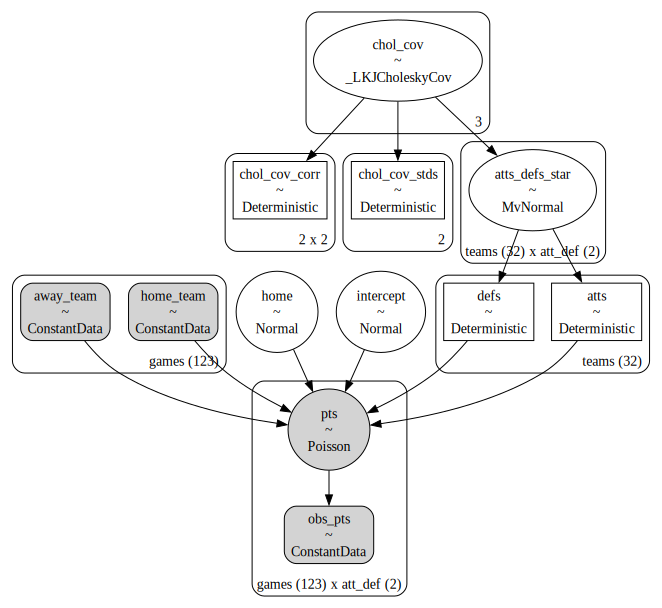

In [4]:
# Visualize model
pm.model_graph.model_to_graphviz(model.model)

In [5]:
# Run inference on 4 cores (1 chain per core)
model.run_inference(tune=1000, draws=1000, target_accept=0.9, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, intercept, chol_cov, atts_defs_star]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


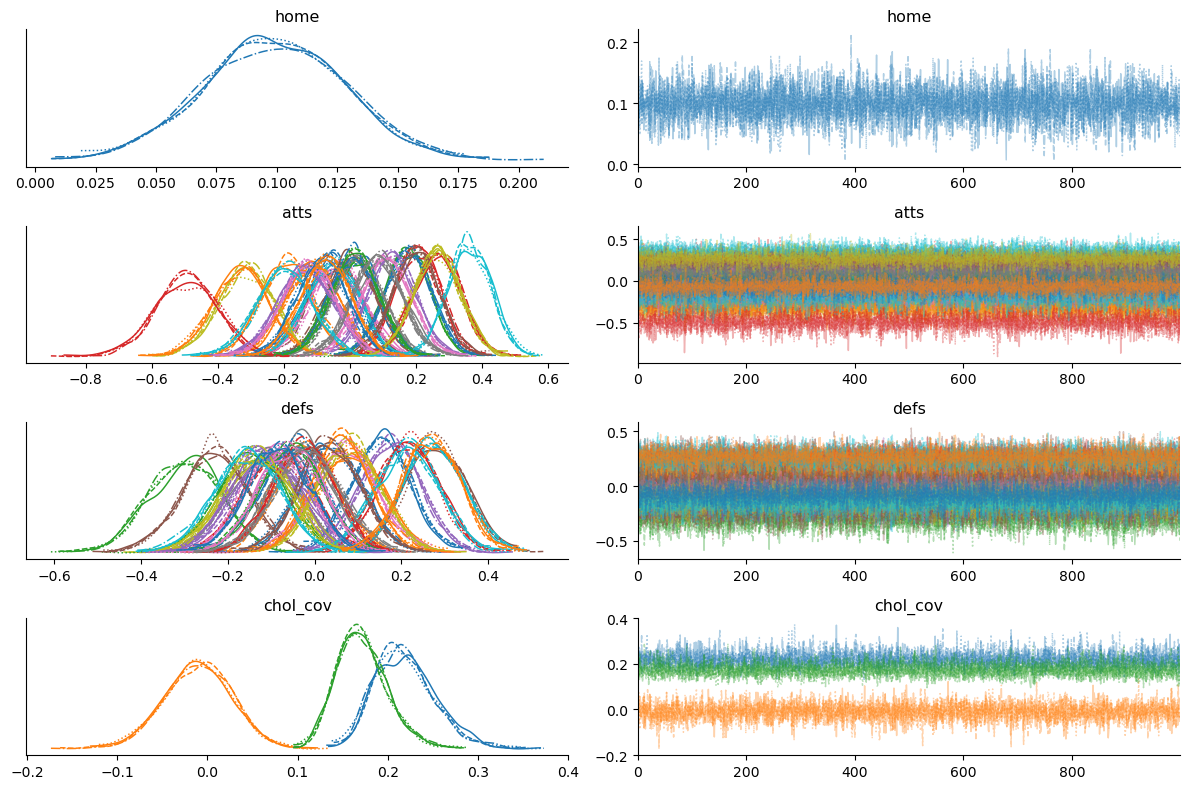

In [6]:
# Examine full posterior distributions and trace for select parameters
axes = az.plot_trace(model.trace_, compact=True, var_names=["home", "atts", "defs", "chol_cov"])

for ii in range(axes.shape[0]):
    for jj in range(axes.shape[1]):
        ax = axes[ii,jj]
        sns.despine(ax=ax)
ax.get_figure().tight_layout()

In [7]:
# Examine MCMC statistics to check convergence
az.summary(model.trace_, group='posterior', var_names=['att'], filter_vars='like')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"atts_defs_star[ARZ, att]",-0.056,0.088,-0.219,0.109,0.001,0.001,3986.0,3076.0,1.0
"atts_defs_star[ARZ, def]",0.154,0.075,0.002,0.286,0.001,0.001,4573.0,3407.0,1.0
"atts_defs_star[ATL, att]",-0.191,0.088,-0.359,-0.028,0.001,0.001,4363.0,3002.0,1.0
"atts_defs_star[ATL, def]",-0.019,0.079,-0.167,0.129,0.001,0.001,5360.0,2985.0,1.0
"atts_defs_star[BLT, att]",0.176,0.081,0.026,0.329,0.001,0.001,2990.0,2960.0,1.0
...,...,...,...,...,...,...,...,...,...
atts[SEA],0.086,0.074,-0.057,0.224,0.001,0.001,6929.0,2911.0,1.0
atts[SF],0.265,0.070,0.129,0.397,0.001,0.001,8192.0,3012.0,1.0
atts[TB],-0.198,0.084,-0.354,-0.036,0.001,0.001,7845.0,3299.0,1.0
atts[TEN],-0.084,0.076,-0.221,0.067,0.001,0.001,8170.0,3055.0,1.0


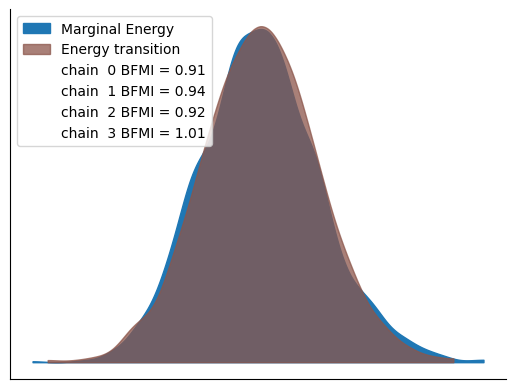

In [8]:
# Same as above, but visualizing energy of chain transition
# Should be ~1 for good convergence
ax = az.plot_energy(model.trace_)
sns.despine(ax=ax)

In [9]:
# Team names, medians, CIs, and colors
team_names = model.trace_.posterior.coords['teams'].values

# Calculate median, 68% CI for atts, defs for each team
med_atts = model.trace_.posterior["atts"].median(axis=1).median(axis=0).values
med_defs = model.trace_.posterior["defs"].median(axis=1).median(axis=0).values

# Calculate median, 68% CI for atts, defs for each team, convert to numpy arrays
defs_CI = az.hdi(model.trace_, var_names=["defs"], hdi_prob=0.68)
defs_CI = defs_CI.to_array().values[0]

atts_CI = az.hdi(model.trace_, var_names=["atts"], hdi_prob=0.68)
atts_CI = atts_CI.to_array().values[0]

# Get primary and secondary colors for pretty plots
pri_colors = list(map(lambda x : utils._hex_color[f"{x}_0"], team_names))
sec_colors = list(map(lambda x : utils._hex_color[f"{x}_1"], team_names))

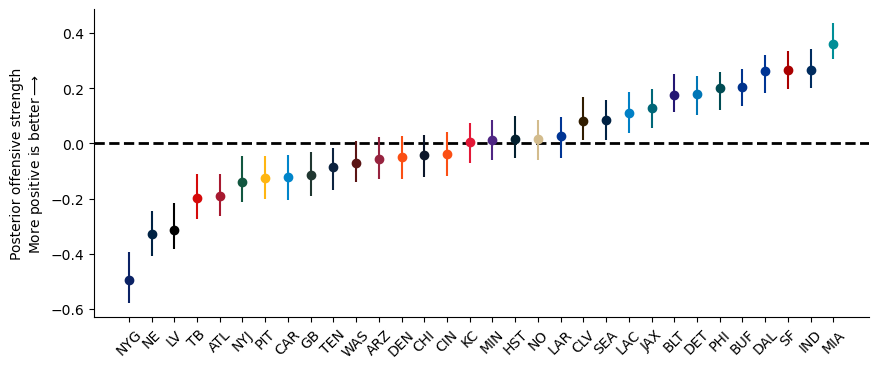

In [10]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(med_atts)

x = np.arange(len(med_atts))
for ii in range(len(x)):
    ax.errorbar(x[ii], med_atts[inds[ii]], 
                yerr=np.asarray([med_atts[inds[ii]] - atts_CI[inds[ii],0], atts_CI[inds[ii],1] - med_atts[inds[ii]]]).reshape(2,1),
                fmt='o', color=pri_colors[inds[ii]])

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_xlabel('')
ax.set_ylabel('Posterior offensive strength\nMore positive is better$\longrightarrow$')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

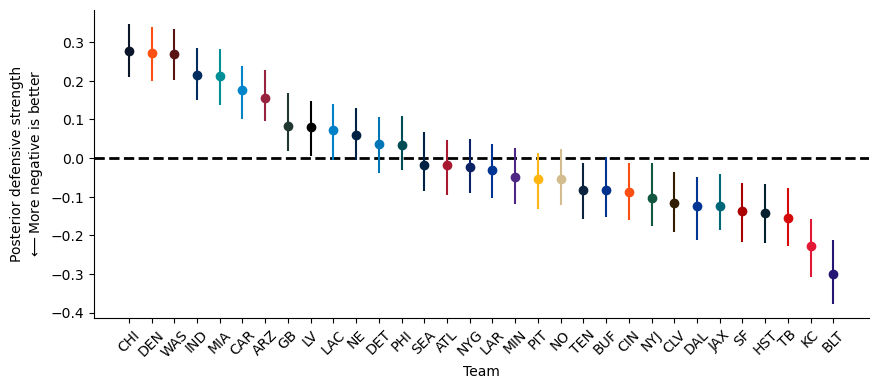

In [11]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(med_defs)[::-1]

x = np.arange(len(med_defs))
for ii in range(len(x)):
    ax.errorbar(x[ii], med_defs[inds[ii]], 
                yerr=np.asarray([med_defs[inds[ii]] - defs_CI[inds[ii],0], defs_CI[inds[ii],1] - med_defs[inds[ii]]]).reshape(2,1),
                fmt='o', color=pri_colors[inds[ii]])

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_xlabel('Team')
ax.set_ylabel('Posterior defensive strength\n$\longleftarrow$More negative is better')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

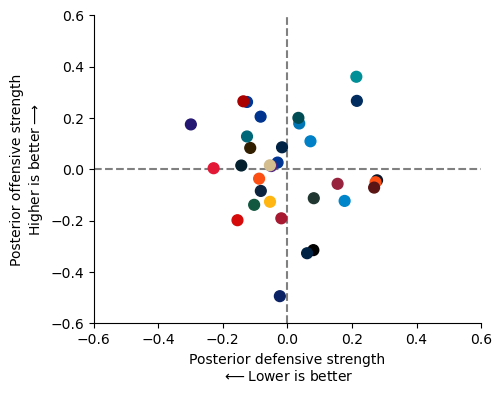

In [12]:
# Plot offensive and defensive strength together
fig, ax = plt.subplots(figsize=(5,4))

im = ax.scatter(med_defs, med_atts, s=60, zorder=1, c=pri_colors)
ax.axhline(0, lw=1.5, ls="--", color="grey", zorder=0)
ax.axvline(0, lw=1.5, ls="--", color="grey", zorder=0)

ax.set_xlabel('Posterior defensive strength\n$\longleftarrow$Lower is better')
ax.set_ylabel('Posterior offensive strength\nHigher is better$\longrightarrow$')
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
sns.despine(ax=ax)

**Simulate many games**

---

Simulate NFL week 9 results to estimate who will win, with what probability, and similar inferences for over/unders, moneyline, and spreads.

In [13]:
away_teams = ["SEA", "WAS", "TB", "CHI", "ARZ", "MIN", "LAR", "IND", "NYG", "DAL", "BUF"]
home_teams = ["BLT", "NE", "HST", "NO", "CLV", "ATL", "GB", "CAR", "LV", "PHI", "CIN"]
ous = [45, 40.5, 40, 42, 38, 39, 37.5, 44.5, 38, 46.5, 50.5]
home_spread = [-6.5, -3, -2.5, -9.5, -12.5, -3.5, -3.5, 2, -2, -3, -2.5]

for home_team, away_team, ou, hs, ii, in zip(home_teams, away_teams, ous, home_spread, np.arange(len(home_teams))):

    # Simulate n game outcomes
    home_pts, away_pts, home_win, tie = model.simulate_game(home_team, away_team, n=10000, seed=None)
    
    total = home_pts + away_pts
    odds = np.mean(total > ou)
    cover = np.mean(home_pts - away_pts > -hs)
    home_ml = np.mean(home_pts > away_pts)
    
    print(f"---{away_team} at {home_team}---")
    print(f"O/U: {ou} - Over odds : {np.round(100*odds, decimals=2):.2f}%")
    print(f"Spread: {home_team} {home_spread[ii]} - odds of {home_team} cover : {np.round(100*cover, decimals=2):.2f}%") 
    print(f"ML: - odds of {home_team} ML : {np.round(100*home_ml, decimals=2):.2f}%")
    print(f"Median outcome: {away_team} {np.median(away_pts):.0f} | {home_team} {np.median(home_pts):.0f}")
    print()

---SEA at BLT---
O/U: 45 - Over odds : 32.59%
Spread: BLT -6.5 - odds of BLT cover : 67.79%
ML: - odds of BLT ML : 90.30%
Median outcome: SEA 16 | BLT 26

---WAS at NE---
O/U: 40.5 - Over odds : 50.08%
Spread: NE -3 - odds of NE cover : 36.70%
ML: - odds of NE ML : 53.22%
Median outcome: WAS 20 | NE 21

---TB at HST---
O/U: 40 - Over odds : 14.04%
Spread: HST -2.5 - odds of HST cover : 64.71%
ML: - odds of HST ML : 75.38%
Median outcome: TB 14 | HST 19

---CHI at NO---
O/U: 42 - Over odds : 74.74%
Spread: NO -9.5 - odds of NO cover : 59.19%
ML: - odds of NO ML : 92.22%
Median outcome: CHI 18 | NO 29

---ARZ at CLV---
O/U: 38 - Over odds : 79.59%
Spread: CLV -12.5 - odds of CLV cover : 42.83%
ML: - odds of CLV ML : 93.06%
Median outcome: ARZ 17 | CLV 28

---MIN at ATL---
O/U: 39 - Over odds : 36.19%
Spread: ATL -3.5 - odds of ATL cover : 18.21%
ML: - odds of ATL ML : 32.05%
Median outcome: MIN 20 | ATL 17

---LAR at GB---
O/U: 37.5 - Over odds : 70.92%
Spread: GB -3.5 - odds of GB cover

**Examine posterior predictive distribution**

---

Simple model evaluation method to see if model can reproduce season total points distribution.

In [14]:
# Sample from posterior predictive distribution
with model.model:
    model.trace_.extend(pm.sample_posterior_predictive(model.trace_))

Sampling: [pts]


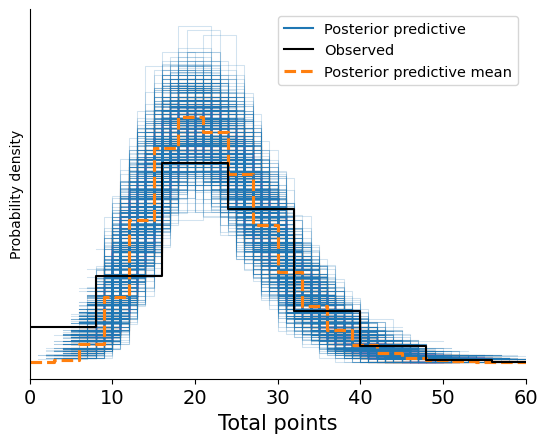

In [15]:
ax = az.plot_ppc(model.trace_, kind='kde', num_pp_samples=1000, group='posterior')
sns.despine(ax=ax)
ax.set_xlim(0, 60)
ax.set_xlabel("Total points")
ax.set_ylabel("Probability density");